In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, LSTM
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
# Load datasets ===
tor = pd.read_csv("Tor_Clean_Server_Web_Browsing.csv")
nontor = pd.read_csv("Non_Tor_Clean_Server_Browsing.csv")

#Remove host-specific features
drop_cols = ["StartTime","EndTime", "SrcIP", "DstIP",
             "SrcPort", "DstPort", "Proto"]

tor_df = tor.drop(columns=drop_cols, errors="ignore")
nontor_df = nontor.drop(columns=drop_cols, errors="ignore")
# Add labels
tor_df["label"] = 1
nontor_df["label"] = 0

# Balance the datasets (if necessary)
min_length = min(len(nontor_df), len(tor_df))
nontor_data = nontor_df.iloc[:min_length]
tor_data = tor_df.iloc[:min_length]

In [3]:
# Combine and shuffle
df = pd.concat([tor_data, nontor_data], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Drop columns where all values are 0
df = df.loc[:, (df != 0).any(axis=0)]

In [4]:
df

,Duration,TotalPackets,TotalBytes,PacketsPerSec,BytesPerSec,FwdPackets,BwdPackets,FwdBytes,BwdBytes,PktLenMin,...,BwdIATMin,BwdIATMax,BwdIATMean,BwdIATStd,TCP_FIN,TCP_SYN,TCP_RST,TCP_PSH,TCP_ACK,label
0,0.146993,2,164,13.606097,1115.699980,1,1,74,90,74,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1
1,0.000000,1,60,0.000000,0.000000,1,0,60,0,60,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1,1
2,258.018587,174,43278,0.674370,167.732102,69,105,27713,15565,54,...,0.000000,46.386624,2.480720,9.776136,1,2,0,88,173,0
3,0.000000,1,54,0.000000,0.000000,1,0,54,0,54,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1,0
4,10.367096,10,2760,0.964590,266.226918,5,5,731,2029,54,...,0.000000,5.294816,2.583222,2.963307,1,2,0,3,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,12.317668,10,3391,0.811842,275.295617,5,5,731,2660,54,...,0.000101,7.244798,3.071041,3.644868,1,2,0,3,9,0
2800,0.000000,1,60,0.000000,0.000000,1,0,60,0,60,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1,1
2801,0.000000,1,60,0.000000,0.000000,1,0,60,0,60,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1,1
2802,0.000000,1,60,0.000000,0.000000,1,0,60,0,60,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1,1


In [5]:
# # Replace both +inf and -inf with NaN
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Drop any rows that contain NaN (i.e., were inf)
# df.dropna(inplace=True)

In [6]:
# Normalize features
scaler = StandardScaler()
X = df.drop("label", axis=1)
y = df["label"]
X_scaled = scaler.fit_transform(X)

In [7]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Store results for comparison
model_results = {}

# 1. Decision Tree
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
model_results['Decision Tree'] = classification_report(y_test, y_pred_dt, output_dict=True)

# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
model_results['Random Forest'] = classification_report(y_test, y_pred_rf, output_dict=True)

# 3. XGBoost
print("Training XGBoost...")
xgb_model = XGBClassifier(n_estimators=300, max_depth=20, learning_rate=0.01, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
model_results['XGBoost'] = classification_report(y_test, y_pred_xgb, output_dict=True)

# 4. MLP (Multi-Layer Perceptron)
print("Training MLP...")
mlp_model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

mlp_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"\nMLP Test Loss: {mlp_loss}, Test Accuracy: {mlp_accuracy}")
model_results['MLP'] = {'accuracy': mlp_accuracy}

# 5. CNN (Convolutional Neural Network)
print("Training CNN...")
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\nCNN Test Loss: {cnn_loss}, Test Accuracy: {cnn_accuracy}")
model_results['CNN'] = {'accuracy': cnn_accuracy}

# 6. RNN (Recurrent Neural Network with LSTM)
print("Training RNN...")
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

rnn_model = Sequential([
    LSTM(128, input_shape=(1, X_train.shape[1]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test, verbose=0)
print(f"\nRNN Test Loss: {rnn_loss}, Test Accuracy: {rnn_accuracy}")
model_results['RNN'] = {'accuracy': rnn_accuracy}

# Visualize Feature Importance for Tree Models
def plot_feature_importance(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

 # plot_feature_importance(rf_model, features, "Random Forest Feature Importance")
 # plot_feature_importance(xgb_model, features, "XGBoost Feature Importance")

# Print Results Summary
for model, results in model_results.items():
    print(f"\nResults for {model}: {results}")

Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70       281
           1       0.68      0.92      0.79       280

    accuracy                           0.75       561
   macro avg       0.78      0.75      0.74       561
weighted avg       0.78      0.75      0.74       561

Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       281
           1       0.75      0.87      0.80       280

    accuracy                           0.79       561
   macro avg       0.80      0.79      0.79       561
weighted avg       0.80      0.79      0.79       561

Training XGBoost...


C:\Users\rafiq\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:13:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       281
           1       0.74      0.86      0.80       280

    accuracy                           0.78       561
   macro avg       0.79      0.78      0.78       561
weighted avg       0.79      0.78      0.78       561

Training MLP...


C:\Users\rafiq\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5791 - loss: 0.8357 - val_accuracy: 0.6347 - val_loss: 0.6502 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6191 - loss: 0.7475 - val_accuracy: 0.5278 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6349 - loss: 0.6669 - val_accuracy: 0.6548 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6373 - loss: 0.6909 - val_accuracy: 0.6637 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6550 - loss: 0.6869 - val_accuracy: 0.6682 - val_loss: 0.5915 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6520 - loss: 0.6278 - val_accuracy: 0.6615 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6594 - loss: 0.6274 - val_accuracy:

C:\Users\rafiq\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5552 - loss: 0.9890 - val_accuracy: 0.6281 - val_loss: 0.6689 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6197 - loss: 0.7660 - val_accuracy: 0.5434 - val_loss: 0.6734 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6628 - loss: 0.6623 - val_accuracy: 0.4878 - val_loss: 0.7053 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6479 - loss: 0.6677 - val_accuracy: 0.4766 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6582 - loss: 0.6617 - val_accuracy: 0.4878 - val_loss: 0.7067 - learning_rate: 5.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6731 - loss: 0.5837 - val_accuracy: 0.4744 - val_loss: 0.7713 - learning_rate: 5.0000e-04

CNN Test Loss: 0.6693329811096191, Test Accuracy: 0.6310160160064697
Training RNN...
Epoch 1/50


C:\Users\rafiq\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5473 - loss: 0.6819 - val_accuracy: 0.5746 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6371 - loss: 0.6315 - val_accuracy: 0.6771 - val_loss: 0.6770 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6699 - loss: 0.5954 - val_accuracy: 0.6837 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6618 - loss: 0.5827 - val_accuracy: 0.6904 - val_loss: 0.6578 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6673 - loss: 0.5623 - val_accuracy: 0.7016 - val_loss: 0.6510 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6830 - loss: 0.5566 - val_accuracy: 0.7038 - val_loss: 0.6454 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6868 - loss: 0.5438 - val_accuracy: 0.7060

 Starting Randomized Search...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

 Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Best Cross-Val F1: 0.8240925472060925

 Confusion Matrix:
[[197  84]
 [ 39 241]]

 Classification Report:
              precision    recall  f1-score   support

           0     0.8347    0.7011    0.7621       281
           1     0.7415    0.8607    0.7967       280

    accuracy                         0.7807       561
   macro avg     0.7881    0.7809    0.7794       561
weighted avg     0.7882    0.7807    0.7794       561


 Top 10 Most Important Features:
1. BwdIATMin: 0.091167
2. PktLenStd: 0.058885
3. PktLenMax: 0.058838
4. PacketsPerSec: 0.056935
5. FwdIATMin: 0.056726
6. BytesPerSec: 0.048286
7. BwdPktLenMax: 0.046527
8. IATMean: 0.043527
9. IATMin: 0.039910
10. BwdPktLenStd: 0.039187


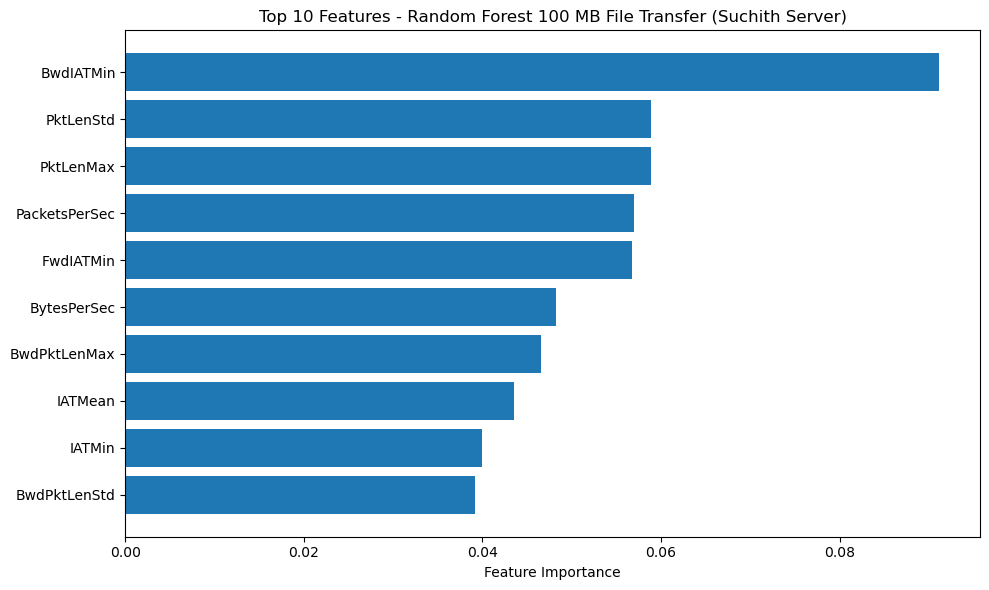

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# === 1. Prepare data ===
# Assuming your dataframe is named df and has a 'label' column
X = df.drop("label", axis=1)
y = df["label"]

# Store column names before scaling
features = X.columns.tolist()

# Scale if you already have X_scaled, otherwise create it:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# === 3. Define Random Forest & parameter grid ===
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=15,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print(" Starting Randomized Search...")
random_search.fit(X_train, y_train)

best_rf_model = random_search.best_estimator_
print("\n Best Parameters:", random_search.best_params_)
print("Best Cross-Val F1:", random_search.best_score_)

# === 4. Evaluate on test set ===
y_pred_rf = best_rf_model.predict(X_test)
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\n Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

# === 5. Get Top 10 Feature Importances ===
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 10
top_features = [(features[i], importances[i]) for i in indices[:top_k]]

print(f"\n Top {top_k} Most Important Features:")
for rank, (name, val) in enumerate(top_features, start=1):
    print(f"{rank}. {name}: {val:.6f}")

# === 6. Plot (Top 10 only) ===
plt.figure(figsize=(10, 6))
plt.barh(range(top_k), [importances[i] for i in indices[:top_k]], align='center')
plt.yticks(range(top_k), [features[i] for i in indices[:top_k]])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_k} Features - Random Forest 100 MB File Transfer (Suchith Server)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [9]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])


Number of rows: 2804
Number of columns: 39


In [10]:
print("Feature names:")
print(df.columns.tolist())


Feature names:
['Duration', 'TotalPackets', 'TotalBytes', 'PacketsPerSec', 'BytesPerSec', 'FwdPackets', 'BwdPackets', 'FwdBytes', 'BwdBytes', 'PktLenMin', 'PktLenMax', 'PktLenMean', 'PktLenStd', 'FwdPktLenMin', 'FwdPktLenMax', 'FwdPktLenMean', 'FwdPktLenStd', 'BwdPktLenMin', 'BwdPktLenMax', 'BwdPktLenMean', 'BwdPktLenStd', 'IATMin', 'IATMax', 'IATMean', 'IATStd', 'FwdIATMin', 'FwdIATMax', 'FwdIATMean', 'FwdIATStd', 'BwdIATMin', 'BwdIATMax', 'BwdIATMean', 'BwdIATStd', 'TCP_FIN', 'TCP_SYN', 'TCP_RST', 'TCP_PSH', 'TCP_ACK', 'label']
